In [17]:
import pandas as pd

train = pd.read_csv("data/density_train.csv", sep=";", decimal=",")
test = pd.read_csv("data/density_test.csv", sep=";", decimal=",")

train["Density"] = train["Density"]
test["Density"] = test["Density"]

display(train.head())
display(test.head())

T  Al2O3  TiO2  Density
0  20    0.0   0.0  1.06250
1  25    0.0   0.0  1.05979
2  35    0.0   0.0  1.05404
3  40    0.0   0.0  1.05103
4  45    0.0   0.0  1.04794

T  Al2O3  TiO2  Density
0  30   0.00   0.0  1.05696
1  55   0.00   0.0  1.04158
2  25   0.05   0.0  1.08438
3  30   0.05   0.0  1.08112
4  35   0.05   0.0  1.07781

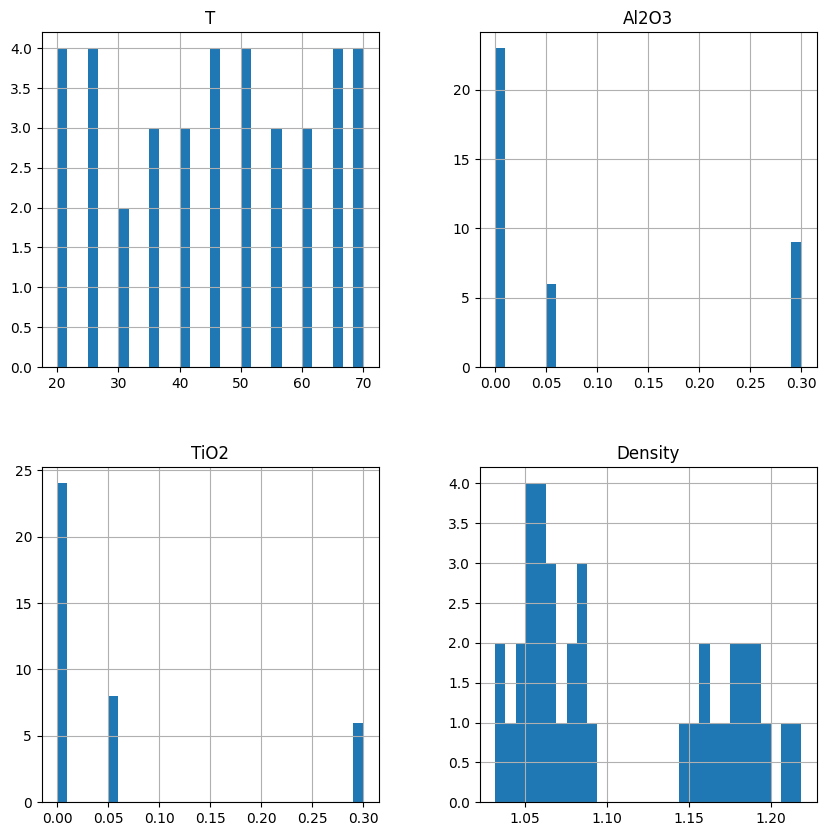

In [18]:
import matplotlib.pyplot as plt

train.hist(bins=30, figsize=(10, 10))
plt.show()

In [19]:
y_train = train["T"]
X_train = train.drop(["T"], axis=1)

display(X_train.head())
display(y_train.head())

y_test = test["T"]
X_test = test.drop(["T"], axis=1)

display(X_test.head())
display(y_test.head())

Al2O3  TiO2  Density
0    0.0   0.0  1.06250
1    0.0   0.0  1.05979
2    0.0   0.0  1.05404
3    0.0   0.0  1.05103
4    0.0   0.0  1.04794

0    20
1    25
2    35
3    40
4    45
Name: T, dtype: int64

Al2O3  TiO2  Density
0   0.00   0.0  1.05696
1   0.00   0.0  1.04158
2   0.05   0.0  1.08438
3   0.05   0.0  1.08112
4   0.05   0.0  1.07781

0    30
1    55
2    25
3    30
4    35
Name: T, dtype: int64

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model, tree, neighbors, ensemble

random_state = 9

models = {
    "linear": {"model": linear_model.LinearRegression(n_jobs=-1)},
    "linear_poly": {
        "model": make_pipeline(
            PolynomialFeatures(degree=2),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "linear_interact": {
        "model": make_pipeline(
            PolynomialFeatures(interaction_only=True),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "ridge": {"model": linear_model.RidgeCV()},
    "decision_tree": {
        "model": tree.DecisionTreeRegressor(random_state=random_state, max_depth=6, criterion="absolute_error")
    },
    "knn": {"model": neighbors.KNeighborsRegressor(n_neighbors=7, n_jobs=-1)},
    "random_forest": {
        "model": ensemble.RandomForestRegressor(
            max_depth=7, random_state=random_state, n_jobs=-1
        )
    },
}

In [21]:
import math
from sklearn import metrics

for model_name in models.keys():
    print(f"Model: {model_name}")
    fitted_model = models[model_name]["model"].fit(
        X_train.values, y_train.values.ravel()
    )
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    models[model_name]["fitted"] = fitted_model
    models[model_name]["RMSE_train"] = math.sqrt(
        metrics.mean_squared_error(y_train, y_train_pred)
    )
    models[model_name]["RMSE_test"] = math.sqrt(
        metrics.mean_squared_error(y_test, y_test_pred)
    )
    models[model_name]["RMAE_test"] = math.sqrt(
        metrics.mean_absolute_error(y_test, y_test_pred)
    )
    models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_pred)

Model: linear
Model: linear_poly
Model: linear_interact
Model: ridge
Model: decision_tree
Model: knn
Model: random_forest


In [22]:
reg_metrics = pd.DataFrame.from_dict(models, "index")[
    ["RMSE_train", "RMSE_test", "RMAE_test", "R2_test"]
]
reg_metrics.sort_values(by="RMSE_test").style.background_gradient(
    cmap="viridis", low=1, high=0.3, subset=["RMSE_train", "RMSE_test"]
).background_gradient(cmap="plasma", low=0.3, high=1, subset=["RMAE_test", "R2_test"])

In [53]:
import numpy as np
from sklearn import model_selection

parameters = {
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": np.arange(1, 21).tolist()[0::2],
    "min_samples_split": np.arange(2, 11).tolist()[0::2],
}

grid = model_selection.GridSearchCV(
    tree.DecisionTreeRegressor(random_state=random_state),
    parameters,
    cv=4,
    n_jobs=-1,
    scoring="r2",
)

grid.fit(X_test, y_test)
grid.best_params_

/Users/user/Projects/python/fuzzy-rules-generator/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'poisson', 'max_depth': 5, 'min_samples_split': 4}

In [54]:
model = grid.best_estimator_
y_pred = model.predict(X_test)
old_metrics = {
    "RMSE_test": models["decision_tree"]["RMSE_test"],
    "RMAE_test": models["decision_tree"]["RMAE_test"],
    "R2_test": models["decision_tree"]["R2_test"],
}
new_metrics = {}
new_metrics["RMSE_test"] = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
new_metrics["RMAE_test"] = math.sqrt(metrics.mean_absolute_error(y_test, y_pred))
new_metrics["MAE_test"] = float(metrics.mean_absolute_error(y_test, y_pred))
new_metrics["R2_test"] = metrics.r2_score(y_test, y_pred)

display(old_metrics)
display(new_metrics)

{'RMSE_test': 6.886687925863586,
 'RMAE_test': 2.394847410096739,
 'R2_test': 0.777676399026764}

{'RMSE_test': 8.194929087252557,
 'RMAE_test': 2.5048971643405977,
 'MAE_test': 6.274509803921568,
 'R2_test': 0.6851851851851851}

In [55]:
rules = tree.export_text(
    models["decision_tree"]["fitted"], feature_names=X_train.columns.values.tolist()
)
print(rules)

|--- Density <= 1.04
|   |--- Density <= 1.03
|   |   |--- value: [70.00]
|   |--- Density >  1.03
|   |   |--- Density <= 1.04
|   |   |   |--- value: [65.00]
|   |   |--- Density >  1.04
|   |   |   |--- value: [60.00]
|--- Density >  1.04
|   |--- Density <= 1.07
|   |   |--- TiO2 <= 0.03
|   |   |   |--- Al2O3 <= 0.03
|   |   |   |   |--- Density <= 1.05
|   |   |   |   |   |--- Density <= 1.05
|   |   |   |   |   |   |--- value: [50.00]
|   |   |   |   |   |--- Density >  1.05
|   |   |   |   |   |   |--- value: [42.50]
|   |   |   |   |--- Density >  1.05
|   |   |   |   |   |--- Density <= 1.06
|   |   |   |   |   |   |--- value: [35.00]
|   |   |   |   |   |--- Density >  1.06
|   |   |   |   |   |   |--- value: [22.50]
|   |   |   |--- Al2O3 >  0.03
|   |   |   |   |--- Density <= 1.06
|   |   |   |   |   |--- Density <= 1.05
|   |   |   |   |   |   |--- value: [70.00]
|   |   |   |   |   |--- Density >  1.05
|   |   |   |   |   |   |--- value: [65.00]
|   |   |   |   |--- Den

In [59]:
import pickle

pickle.dump(
    models["decision_tree"]["fitted"], open("data/temp_density_tree.model.sav", "wb")
)

In [57]:
rules2 = tree.export_text(model, feature_names=X_train.columns.values.tolist())
print(rules2)

|--- Density <= 1.21
|   |--- TiO2 <= 0.03
|   |   |--- Density <= 1.07
|   |   |   |--- value: [48.33]
|   |   |--- Density >  1.07
|   |   |   |--- Al2O3 <= 0.18
|   |   |   |   |--- Density <= 1.08
|   |   |   |   |   |--- value: [37.50]
|   |   |   |   |--- Density >  1.08
|   |   |   |   |   |--- value: [27.50]
|   |   |   |--- Al2O3 >  0.18
|   |   |   |   |--- value: [50.00]
|   |--- TiO2 >  0.03
|   |   |--- Density <= 1.19
|   |   |   |--- TiO2 <= 0.18
|   |   |   |   |--- value: [50.00]
|   |   |   |--- TiO2 >  0.18
|   |   |   |   |--- value: [65.00]
|   |   |--- Density >  1.19
|   |   |   |--- value: [40.00]
|--- Density >  1.21
|   |--- value: [25.00]



In [58]:
import pickle

pickle.dump(model, open("data/temp_density_tree-gs.model.sav", "wb"))